In [21]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model
from sklearn.cross_decomposition import PLSRegression

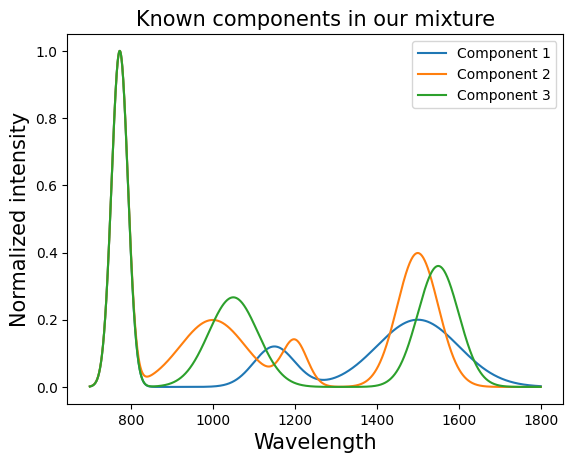

In [22]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(700, 1800, 2000)
# First component
mu_a1 = 773
sigma_a1 = 20
intensity_a1 = 1

mu_a2 = 1150
sigma_a2 = 50
intensity_a2 = 0.3

mu_a3 = 1500
sigma_a3 = 100
intensity_a3 = 1

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 773
sigma_b1 = 20
intensity_b1 = 1

mu_b2 = 1000
sigma_b2 = 80
intensity_b2 = 0.8

mu_b3 = 1200
sigma_b3 = 30
intensity_b3 = 0.2

mu_b4 = 1500
sigma_b4 = 50
intensity_b4 = 1

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 773
sigma_c1 = 20
intensity_c1 = 1

mu_c2 = 1050
sigma_c2 = 60
intensity_c2 = 0.8

mu_c3 = 1550
sigma_c3 = 50
intensity_c3 = 0.9

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2) + Gauss(x_range, mu_c3, sigma_c3, intensity_c3)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

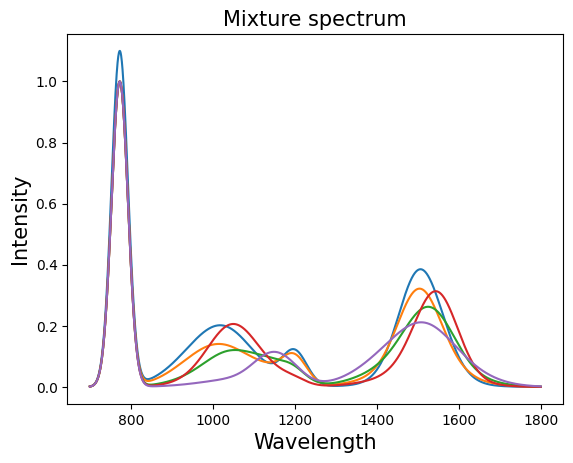

In [23]:
c_a = [0.1, 0.3, 0.5, 0.2, 0.9]
c_b = [0.8, 0.6, 0.2, 0.1, 0.05]
c_c = [0.2, 0.1, 0.3, 0.7, 0.05]

# Mixture
mixture = np.array([c_a, c_b, c_c]).T @ np.array([component_a, component_b, component_c])
# How does it look?
plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()


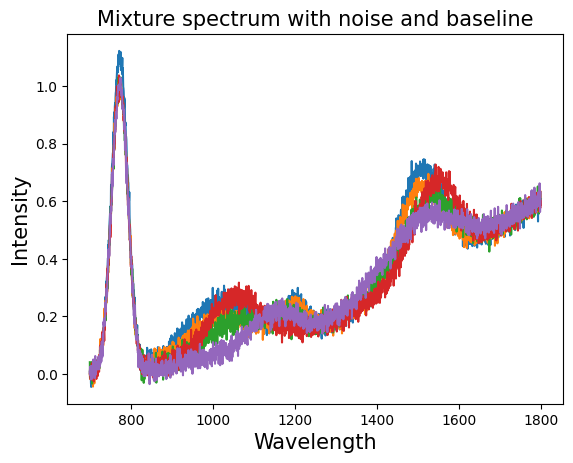

In [24]:
# Let's add some noise for a bit of realism:

# Random noise:
mixture += np.random.normal(0, 0.02, size = mixture.shape)

# Baseline:

# Baseline as a polynomial background:
poly = 0.001 * np.ones(len(x_range)) + 0.000001 * x_range + 0.0000005 * (x_range - 700)**2
mixture += poly


plt.plot(x_range, mixture.T)
plt.title('Mixture spectrum with noise and baseline', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

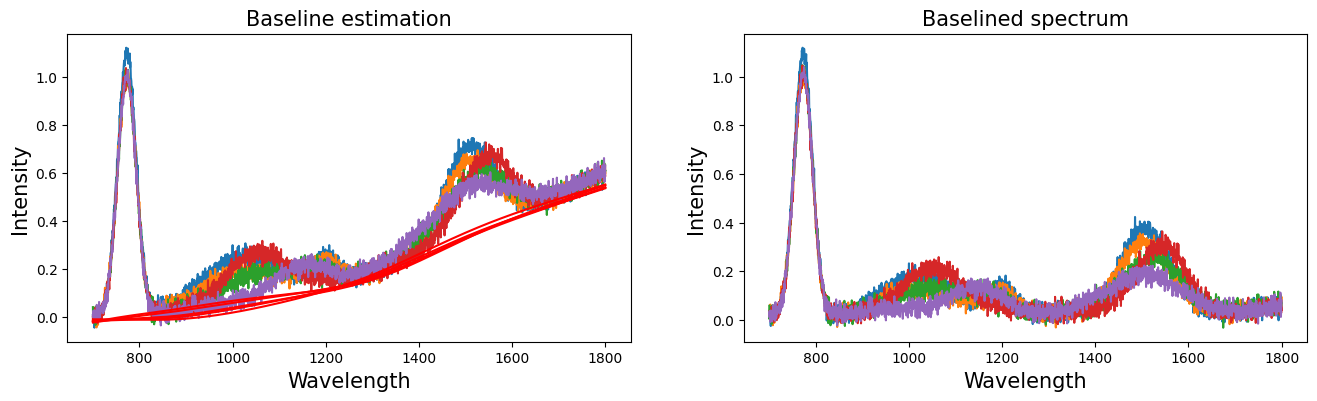

In [25]:
# Estimation of the baseline:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.0009 # asymmetry
estimated_baselined = []
for i in range(mixture.shape[0]):
    estimated_baselined.append(baseline_als(mixture[i], l, p))
estimated_baselined = np.array(estimated_baselined).T

# Baseline subtraction:
baselined_spectrum = mixture.T - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(x_range, mixture.T)
ax1.plot(x_range, estimated_baselined, color = 'red')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)


# We plot the mix spectrum after baseline subtraction
ax2.plot(x_range, baselined_spectrum )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()


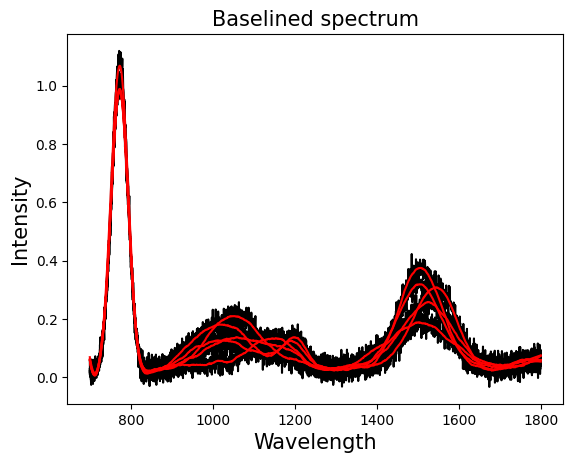

In [26]:
# Parameters:
w = 100 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = []
for i in range(baselined_spectrum.shape[1]):
    smoothed_spectrum.append(savgol_filter(baselined_spectrum[:,i], w, polyorder = p, deriv=0))
smoothed_spectrum = np.array(smoothed_spectrum)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/


# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum.T, color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [27]:
smoothed_spectrum.shape

(5, 2000)

In [28]:
# Find best number of components using PRESS and cross-validation
# Parameters:
n_components = smoothed_spectrum.shape[1]
n_folds = 10

for i in range(1, n_components + 1):
    pls = PLSRegression(n_components = i)
    pls.fit(smoothed_spectrum, c_a)
    y_cv = pls.predict(smoothed_spectrum)
    press = np.sum((c_a - y_cv)**2, axis = 0)
    press = np.cumsum(press)
    press = press[-1]
    print('PRESS for ' + str(i) + ' components: ' + str(press))
    #Machine precision
    tol = np.finfo(float).eps
    if press < tol:
        print('The best number of components is: ' + str(i))
        break


PRESS for 1 components: 0.025311615503540115
PRESS for 2 components: 0.004550528774922094
PRESS for 3 components: 6.176684230949352e-05
PRESS for 4 components: 7.780756975324433e-32
The best number of components is: 4


In [29]:
pls = PLSRegression(n_components = 4)
concentrations = np.array([c_a, c_b, c_c]).T
pls.fit(smoothed_spectrum, concentrations)

PLSRegression(n_components=4)

In [30]:
concentrations_pred = pls.predict(smoothed_spectrum)
concentrations_pred = concentrations_pred.T
concentrations_pred

array([[0.1 , 0.3 , 0.5 , 0.2 , 0.9 ],
       [0.8 , 0.6 , 0.2 , 0.1 , 0.05],
       [0.2 , 0.1 , 0.3 , 0.7 , 0.05]])

In [31]:
concentrations.T

array([[0.1 , 0.3 , 0.5 , 0.2 , 0.9 ],
       [0.8 , 0.6 , 0.2 , 0.1 , 0.05],
       [0.2 , 0.1 , 0.3 , 0.7 , 0.05]])